In [131]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 

In [132]:
# Step1 데이터셋 만들기 
def make_dataset(npoints=100, x_std=0.5, r_std=0.05, w=2.0, b=1.0, seed=0):
  """선형회귀를 위한 데이터셋을 만들어주는 함수입니다. 

  npoints (int) : 몇 개의 점을 만들지를 결정합니다. 
  x_std (float) : x 값들을 0.0을 기준으로 얼마나 퍼뜨릴지를 결정합니다. std는 standard deviation (표준편차)의 약자입니다.
  r_std (float) : residual(잔차 혹은 오차)를 얼마나 퍼뜨릴지를 결정합니다. r_std가 0 이면 모든 점들은 직선 위에 있게 됩니다. 
  w (float) : 직선의 기울기를 의미합니다. 선형 회귀 시 예측해야할 기울기가 됩니다. 
  b (float) : 직선의 y절편을 의미합니다. 선형 회귀 시 예측해야할 bias를 의미합니다. 
  seed : 랜덤 값을 결정해주는 역할을 합니다. 똑같은 데이터를 seed를 똑같이 주면 얻을 수 있습니다. 
  """
  points = list() 
  np.random.seed(seed)
  for i in range(npoints):
    x = np.random.normal(0.0, x_std)
    r = np.random.normal(0.0, r_std)
    y = w * x + b + r
    points.append([x, y])  

  points = np.array(points)  # 리스트를 numpy 배열로 바꿉니다. 
  corr = np.corrcoef(points[:, 0], points[:, 1])[0, 1]  # x, y의 상관관계를 구합니다.

  points_tensor = torch.FloatTensor(points)  # 넘파이 배열을 텐서로 바꿈
  x = points_tensor[:, 0]  # 사이즈 (100)
  x = x.unsqueeze(1)  # 사이즈를 (100, 1)
  y = points_tensor[:, 1]
  y = y.unsqueeze(1) 

  return points, corr, x, y 

In [133]:
def print_dataset(dataset):
  plt.figure(1)
  for point in dataset:
    plt.scatter(point[0], point[1], c='b')
  plt.grid()

상관계수:  0.9622962421701883


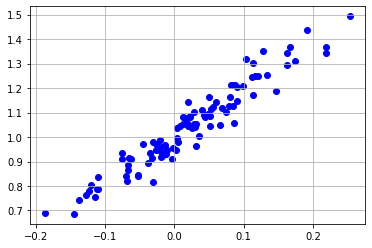

In [138]:
data_numpy, corr, x, y = make_dataset(100, 0.1, 0.05, 2., 1., 1)  # default 값이 있을 때 안 적어도 됨
print("상관계수: ", corr)
print_dataset(data_numpy)

In [183]:
class LinearRegression(torch.nn.Module):
  """예측해야할 가중치와 편차를 하나의 클래스로 묶어줍니다.
  """
  def __init__(self):
    super().__init__()
    self.w = torch.nn.Parameter(torch.randn(1, requires_grad=True))  # 예측할 회귀선의 기울기 초기값
    self.b = torch.nn.Parameter(torch.zeros(1, requires_grad=True))  # 예측할 회귀선의 편차 초기값

  def forward(self, x):
    y_hat = self.w * x + self.b
    return y_hat

In [184]:
# 모델 사용법 예시 
model = LinearRegression()
print("기울기 초기값: ",model.w)
print("편차 초기값: ", model.b)

기울기 초기값:  Parameter containing:
tensor([1.3650], requires_grad=True)
편차 초기값:  Parameter containing:
tensor([0.], requires_grad=True)


In [252]:
class LinearRegressionTrainer():
  """선형 회귀 모델을 학습하기 위한 클래스
  """
  def __init__(self, learning_rate=0.01):
    self.model = LinearRegression()  # 모델을 정의 
    self.optimizer = self._set_optimizer(self.model, learning_rate)  # 최적화 함수 정의 (기울기 하강법을 사용하는 함수)
    self.train_params = list()  # 학습 도중에 나오는 모델의 w, b로 그래프를 그리기 위해서 정의 
  
  def _set_optimizer(self, model, lr):
    """ 최적화 함수를 정의하는 함수 
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return optimizer
  
  def calculate_error(self, y_true, y_pred):
    """ 오차를 계산하는 함수
    """
    error = torch.mean((y - y_pred) ** 2)
    return error

  def train(self, x, y, total_steps, print_step, save_step):
    
    for step in range(total_steps):
      y_pred = self.model(x)
      error = self.calculate_error(y, y_pred)
      self.model.zero_grad()
      self.optimizer.zero_grad()  # gradient 초기화 
      error.backward()  # gradient 계산 
      self.optimizer.step()

      if step % print_step == 0:
        print("Step: {}, Error: {}".format(step, error.data.numpy()))

      if step % save_step == 0:
        self.train_params.append([self.model.w, self.model.b])

    return self.train_params

  def predict(self, x):
    y_pred = self.model(x) 
    return y_pred

In [253]:
trainer = LinearRegressionTrainer()
params = trainer.train(x, y, total_steps=100, print_step=100, save_step=20)

Step: 0, Error: 1.104171633720398


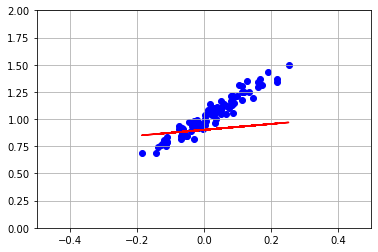

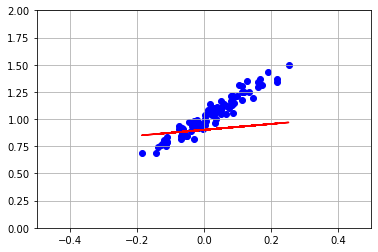

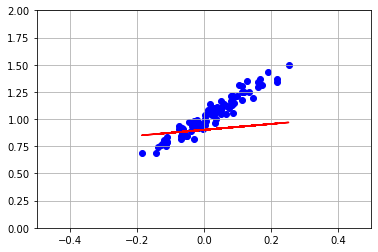

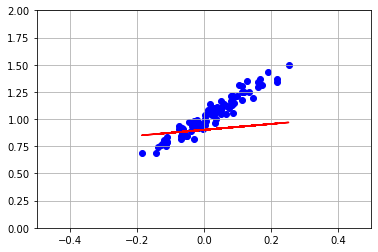

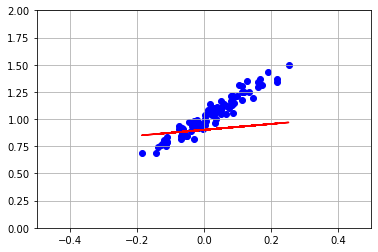

In [254]:
for i in range(len(params)):
  y_pred = params[i][0] * x + params[i][1] 
  y_pred = y_pred.squeeze(1).data.numpy()
  plt.figure(i)
  plt.plot(1, len(params), i+1)
  plt.xlim(-0.5, 0.5)
  plt.ylim(0, 2)
  for xx, yy in zip(x, y):
    plt.scatter(xx, yy, c='b')
  plt.plot(x, y_pred, c='r')
  plt.grid()